In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF

#### 각 크립토 시장 데이터 불러오기

In [2]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

#### Q(투자자 기대 수익률) 불러오기

In [3]:
# Q 벡터를 pickle 파일에서 불러오기
with open('q_vector_epoch_standard.pkl', 'rb') as f:
    Q = pickle.load(f)

dates = pd.date_range(start='2023-06-01', end='2023-12-31')
# Q 딕셔너리를 DataFrame으로 변환
Q_df = pd.DataFrame.from_dict(Q, orient='index', columns=dates)

# [[]] 구조를 제거하고 단일 값으로 변환
for col in Q_df.columns:
    Q_df[col] = Q_df[col].apply(lambda x: x[0][0] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], list) and len(x[0]) > 0 else x)

Q_df

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,0.094071,0.088301,-0.041694,0.085761,0.087246,0.105428,5.750444,0.100979,0.104826,0.091158,...,0.088653,0.083388,0.075581,0.084399,0.083804,0.097981,0.081933,0.089194,0.087141,0.002615
ETH,-0.114111,0.548993,-0.113537,-0.036382,-0.707749,2.372194,-0.474071,0.265970,-0.090349,-1.539414,...,0.185284,-0.031254,-0.081653,0.012927,-0.019695,0.301354,-0.021056,-0.040462,-0.013458,0.013455
BNB,0.069069,0.007290,-0.044625,-0.053058,-0.032416,0.067616,0.003531,0.056366,0.031905,5.602673,...,-0.225526,0.100318,-1.032513,0.275207,4.329243,-0.061954,0.187073,0.326248,0.241691,0.225205
DOT,1.980556,-0.430430,-0.595831,0.756244,4.503277,-0.451664,1.126253,-0.050100,0.090094,1.159220,...,-0.112366,0.124677,0.101423,0.141685,-0.083123,-0.016641,-0.053526,-0.008629,0.024821,-0.029892
SOL,0.052946,-0.046407,0.082130,-0.033814,0.405551,-0.024508,0.318390,0.051911,0.195505,0.171065,...,0.017075,0.085527,0.030321,0.074902,0.014783,0.049110,0.015458,0.034749,-0.006722,-0.039591
FTT,0.020808,0.007602,-0.007386,-0.008285,0.120431,0.136972,-0.005059,-0.030855,0.410207,0.086426,...,0.055957,0.081007,0.025930,-0.011120,0.023137,0.033608,0.000522,0.051499,0.043420,0.024505
XRP,-0.917126,-0.159290,-0.193372,0.438565,-0.459500,208.932205,-0.277481,-0.996364,-0.075521,-0.266824,...,-0.083487,0.134498,0.589629,0.012169,-0.069026,-0.216622,-0.243168,-0.059124,0.056881,0.221704
UNI,-0.663362,-0.397343,-0.385436,0.156743,0.037469,-0.129893,-0.005448,-0.162569,-0.105976,-0.024969,...,-0.129512,-0.066014,-0.084321,-0.189017,-0.095067,-0.078229,-0.046251,-0.125240,0.025753,-0.137938


In [4]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    
    del df['고가']
    del df['시가']
    del df['저가']
    del df['거래량']
    del df['종가']
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']
    df['변동 %'] = df['변동 %'].str.replace('%', '').astype(float)
    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2

In [5]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
returns = pd.DataFrame(index=all_dates)

# StandardScaler 인스턴스 생성
scaler = StandardScaler()

for ticker, df in filtered_dfs.items():
    df.set_index('created_at', inplace=True)  # 'created_at'을 인덱스로 설정
    df = df.reindex(all_dates)  # 모든 날짜에 대해 데이터프레임을 재정렬
    
    # '변동 %' 데이터를 100으로 나누고 로그 변환 적용
    df['변동 %'] = df['변동 %'].replace(',','').astype(float) / 100  # 쉼표 제거 후 float 타입으로 변환
    df['변동 %'] = np.log1p(df['변동 %'])  # 로그 변환 적용

    # StandardScaler를 적용하여 데이터 스케일링
    scaled_returns = scaler.fit_transform(df[['변동 %']])

    # 스케일링된 데이터를 데이터프레임에 추가
    returns[ticker] = scaled_returns

# 반환된 데이터프레임 확인
print(returns)

                 BTC       ETH       BNB       DOT       SOL       FTT  \
2023-06-01 -0.818807 -0.325711 -0.261292 -0.700417 -0.475384 -0.254064   
2023-06-02  0.670182  1.038813  0.335889  0.353795  0.596650  0.378442   
2023-06-03 -0.409091 -0.398210 -0.098706  0.292951 -0.218065 -0.503282   
2023-06-04 -0.007658 -0.090892 -0.207026 -0.198182  0.459429  0.320272   
2023-06-05 -2.641923 -1.957705 -4.000304 -1.538869 -1.951271 -1.268999   
...              ...       ...       ...       ...       ...       ...   
2023-12-27  0.962610  2.846755  3.494207 -0.490417 -1.243393 -0.293481   
2023-12-28 -1.082242 -0.693944 -0.156997 -1.003830 -1.124514 -1.005108   
2023-12-29 -0.685148 -0.918175 -1.203388 -0.565476  0.701433 -0.540013   
2023-12-30 -0.027163 -0.190089  0.393492  0.134190 -1.014892  1.411695   
2023-12-31  0.055682 -0.235251 -0.609445 -0.584270 -0.195393 -1.228582   

                 XRP       UNI  
2023-06-01 -0.448273 -0.273318  
2023-06-02  0.738394  0.410273  
2023-06-03 -

#### RMSE & MAE 계산

In [6]:
transposed_returns = returns.transpose()
transposed_returns

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,-0.818807,0.670182,-0.409091,-0.007658,-2.641923,2.635175,-1.719335,0.191829,-0.139473,-1.287011,...,0.011840,-0.389432,-0.923017,0.573922,-1.307035,0.962610,-1.082242,-0.685148,-0.027163,0.055682
ETH,-0.325711,1.038813,-0.398210,-0.090892,-1.957705,1.736147,-1.300563,0.290326,-0.172037,-2.268633,...,1.627898,-0.343824,-0.927351,0.115815,-0.853995,2.846755,-0.693944,-0.918175,-0.190089,-0.235251
BNB,-0.261292,0.335889,-0.098706,-0.207026,-4.000304,0.594478,-3.369781,0.426373,-0.227889,-3.631714,...,-0.094545,-0.019727,-0.994539,0.372929,4.560260,3.494207,-0.156997,-1.203388,0.393492,-0.609445
DOT,-0.700417,0.353795,0.292951,-0.198182,-1.538869,0.752384,-1.153472,-0.059258,-0.325305,-3.059177,...,-1.850696,1.402511,0.937835,1.923888,-1.358417,-0.490417,-1.003830,-0.565476,0.134190,-0.584270
SOL,-0.475384,0.596650,-0.218065,0.459429,-1.951271,0.244809,-2.011939,0.137666,-1.846090,-2.363723,...,0.715232,1.840647,0.691570,1.309586,-1.590978,-1.243393,-1.124514,0.701433,-1.014892,-0.195393
FTT,-0.254064,0.378442,-0.503282,0.320272,-1.268999,0.237444,0.138367,2.084237,-1.743096,-1.581992,...,-0.243653,0.204143,-0.001128,-0.241341,-0.706181,-0.293481,-1.005108,-0.540013,1.411695,-1.228582
XRP,-0.448273,0.738394,-0.258876,0.674164,-1.119020,0.845704,-0.492050,0.208480,0.557645,-1.295726,...,-0.008923,-0.183151,-0.278391,1.142128,-0.832163,0.406898,-0.013208,-0.411132,-0.094785,-0.202598
UNI,-0.273318,0.410273,0.050709,-0.421912,-1.630053,0.212583,-1.294850,0.397139,-0.313761,-3.248462,...,0.842693,-0.267930,1.998212,0.441768,1.374824,-0.446306,1.988312,-0.894771,-0.784693,-0.549550


In [7]:
# 티커별로 오차 계산
tickers = ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI']
for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    print(f"{ticker} RMSE: {rmse}")

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)
    print(f"{ticker} MAE: {mae}")

BTC RMSE: 1.4985664082528065
BTC MAE: 0.8487280198193704
ETH RMSE: 1.1233771192880653
ETH MAE: 0.691244503335154
BNB RMSE: 1.1803518213532194
BNB MAE: 0.6875844984369696
DOT RMSE: 1.9304753059704383
DOT MAE: 1.1312112162833938
SOL RMSE: 1.25197018958556
SOL MAE: 0.8784279889805151
FTT RMSE: 1.270906817364685
FTT MAE: 0.721987747143818
XRP RMSE: 14.267231464772026
XRP MAE: 1.554523812573369
UNI RMSE: 5.939161586684841
UNI MAE: 1.2453555888644454


#### R2 & MAPE 값 추가

In [8]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 결과를 저장하기 위한 딕셔너리
results = {}

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]
    
    # 오차 지표 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    mae = mean_absolute_error(actual_returns, expected_returns)
    mape = calculate_mape(actual_returns, expected_returns)
    r_squared = r2_score(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r_squared}

# 결과 출력
for ticker, metrics in results.items():
    print(f"{ticker}:")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  R2: {metrics['R2']:.2f}")
    print("------")


BTC:
  RMSE: 1.50
  MAE: 0.85
  MAPE: 213.24%
  R2: -1.25
------
ETH:
  RMSE: 1.12
  MAE: 0.69
  MAPE: 133.83%
  R2: -0.26
------
BNB:
  RMSE: 1.18
  MAE: 0.69
  MAPE: 145.04%
  R2: -0.39
------
DOT:
  RMSE: 1.93
  MAE: 1.13
  MAPE: 159.93%
  R2: -2.73
------
SOL:
  RMSE: 1.25
  MAE: 0.88
  MAPE: 140.80%
  R2: -0.57
------
FTT:
  RMSE: 1.27
  MAE: 0.72
  MAPE: 179.86%
  R2: -0.62
------
XRP:
  RMSE: 14.27
  MAE: 1.55
  MAPE: 1244.25%
  R2: -202.55
------
UNI:
  RMSE: 5.94
  MAE: 1.25
  MAPE: 235.40%
  R2: -34.27
------


In [9]:
# 결과를 저장할 딕셔너리
results = {}
transformed_market_data = pd.DataFrame()

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]
    

    transformed_market_data[ticker] = transposed_returns.loc[ticker] 

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)

    # R2 계산
    r_squared = r2_score(actual_returns, expected_returns)

    # MAPE 계산
    mape = calculate_mape(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r_squared,
        'MAPE': mape
        }

#### 그래프 비교

In [10]:
transformed_market_data = transformed_market_data.transpose()

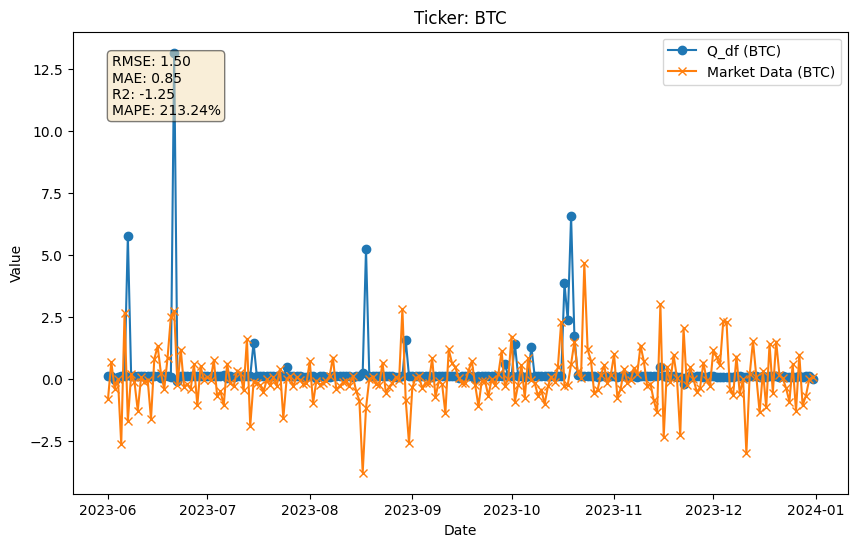

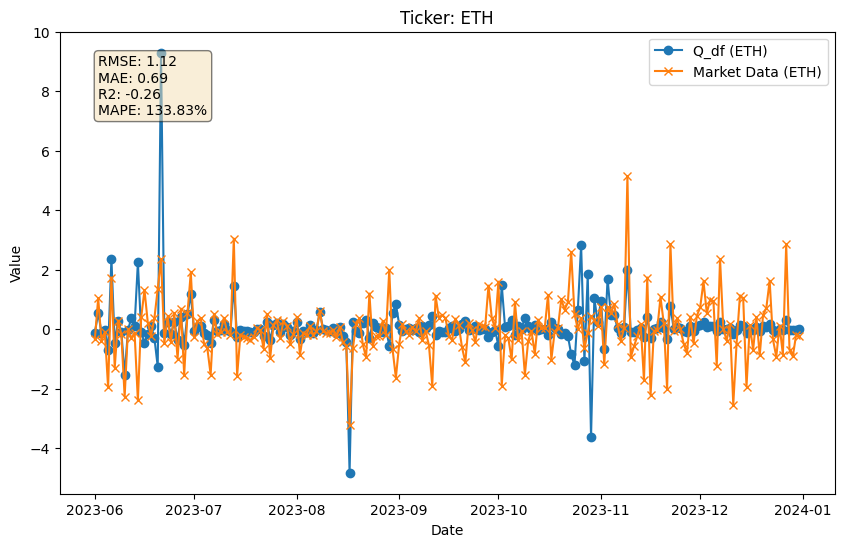

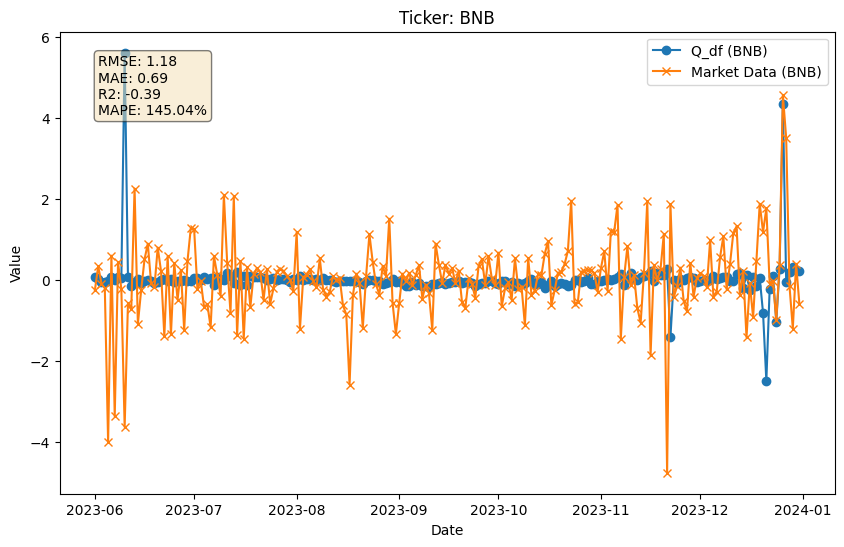

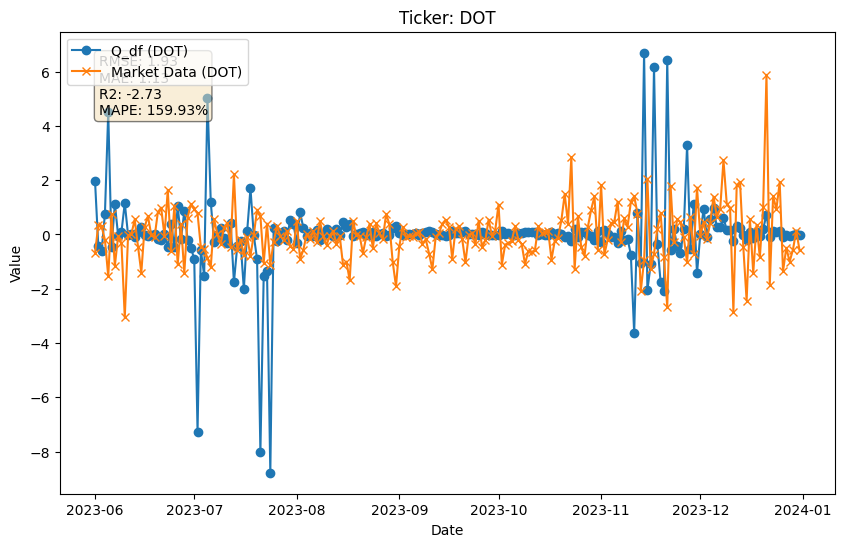

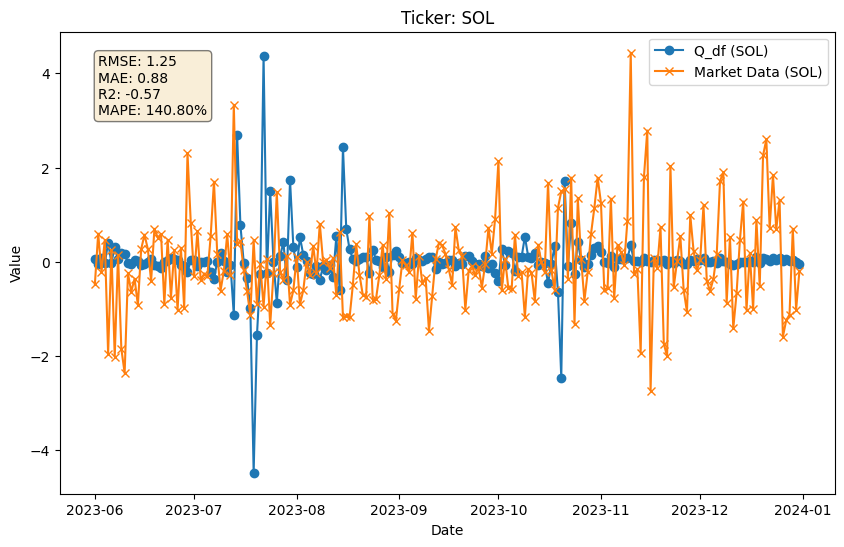

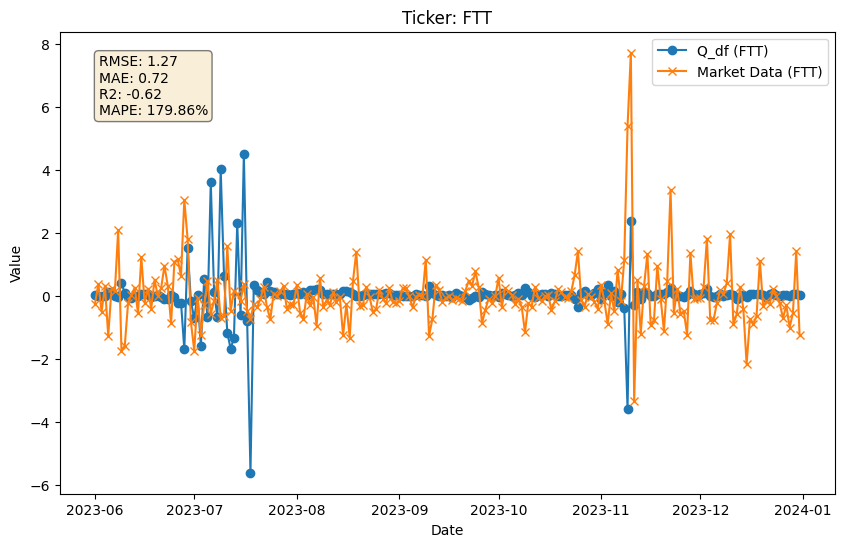

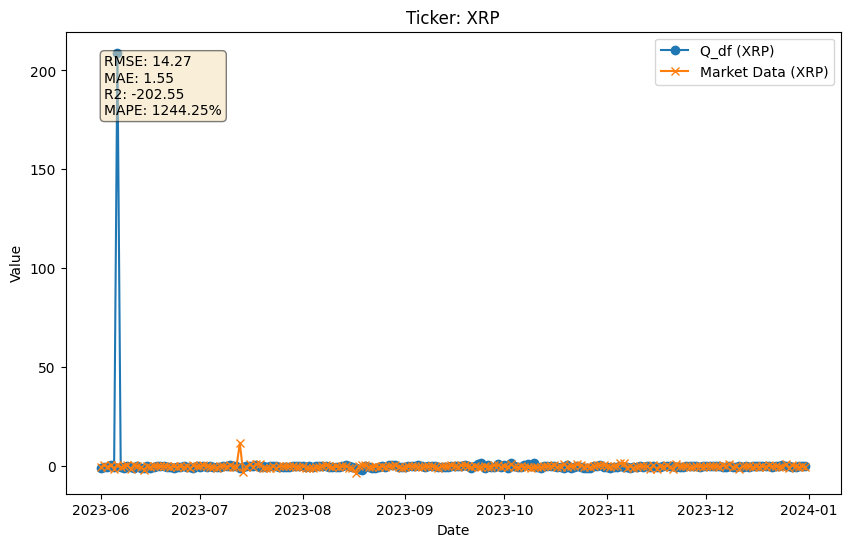

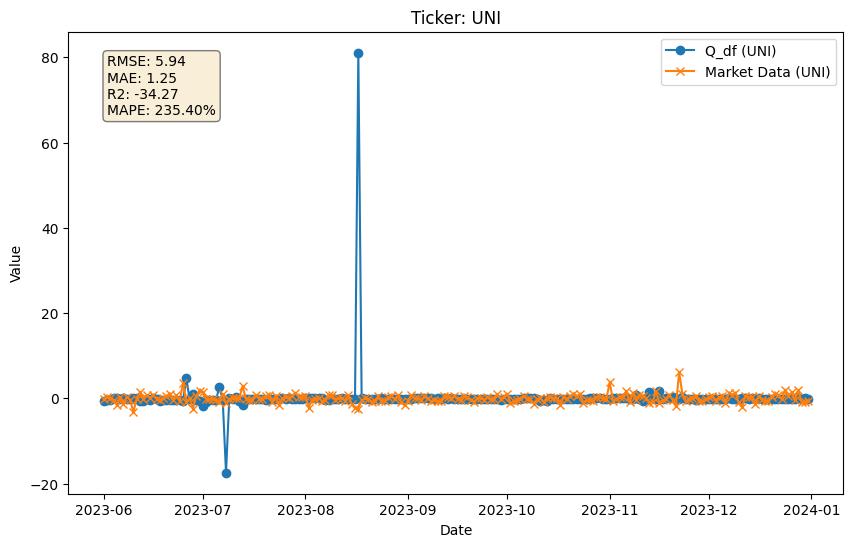

In [11]:
for ticker in tickers:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Q_df와 시장 데이터 플롯
    ax.plot(Q_df.loc[ticker].index, Q_df.loc[ticker], label=f'Q_df ({ticker})', marker='o')
    ax.plot(transformed_market_data.loc[ticker].index, transformed_market_data.loc[ticker], label=f'Market Data ({ticker})', marker='x')

    # 오차 지표 추가
    metrics = results[ticker]
    textstr = '\n'.join((
        f'RMSE: {metrics["RMSE"]:.2f}',
        f'MAE: {metrics["MAE"]:.2f}',
        f'R2: {metrics["R2"]:.2f}',
        f'MAPE: {metrics["MAPE"]:.2f}%'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # 그래프 설정
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'Ticker: {ticker}')
    ax.legend()
    plt.show()